In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import os
import warnings
import json
from datetime import datetime, date
import os
import shapefile
from shapely.geometry import box
from datetime import datetime as dt
import pyproj
import rasterio
from rasterio.mask import mask
from shapely.ops import transform
from rasterio.io import MemoryFile
import earthpy.plot as ep
from folium import Map, GeoJson, Figure
import rioxarray as rxr
import rasterio as rio
import yaml
# open shape files for Cameroon
import geopandas as gpd

In [3]:
# Open file for credentials
PATH = '/Users/noeliaotero/Documents/Geo_analysis/'
# Read YAML file
with open(PATH + "config_sentinel.yml", 'r') as stream:
    s_conf = yaml.safe_load(stream)

In [4]:
PATH_DATA='/Users/noeliaotero/Documents/Geo_analysis/ESA_WorldCover'

In [5]:
gdf = gpd.read_file(s_conf['footprint_file'])
# Set the crs to EPSG 4326 in case of our data is in aonther crs
gdf  = gdf.to_crs("EPSG:4326")
# Get AOI bounds
bbox_aoi = gdf.geometry.total_bounds
# Get AOI centroid for plotting with folium
centroid_aoi = [box(*bbox_aoi).centroid.x, box(*bbox_aoi).centroid.y]
print(bbox_aoi)

[12.17747531  5.02154296 12.17747531  5.02154296]


In [6]:
from pystac_client import Client


stac_endopoint = 'https://services.terrascope.be/stac/'

# collection ids for both maps in the Terrascope STAC Catalogue
collection_ids = {2020: 'urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1',
                  2021: 'urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2'}

# WSG84 coordinates of Doula are 4.051056, 9.767869, so I select values around (BUT I should change this!!!) 
# If I use a bigger area , the img is quite to process...
bbox = [4.051056, 9.767869, 4.551056, 10.267869]




client = Client.open(stac_endopoint)

# Let's query products for the 2021 map 
year = 2021
search_results = client.search(
    collections=[collection_ids[year]],
    bbox=list(bbox)
)

# Search results fetched and represented as dictionary
results = search_results.get_all_items()
# results.to_dict()

In [7]:
# there is only 1 tile
item = results[0]

# retrieve the s3 path from the item
s3uri = item.assets['ESA_WORLDCOVER_10M_MAP'].href
s3uri

's3://esa-worldcover/v200/2021/map/ESA_WorldCover_10m_2021_v200_N09E003_Map.tif'

In [8]:
from labels import *
import os
from rio_tiler.io import STACReader

# this is to tell GDAL we do not need authentication
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# name of the map asset
asset = 'ESA_WORLDCOVER_10M_MAP'

with STACReader(None, item=item) as stac:
    img = stac.part(bbox, assets=asset)

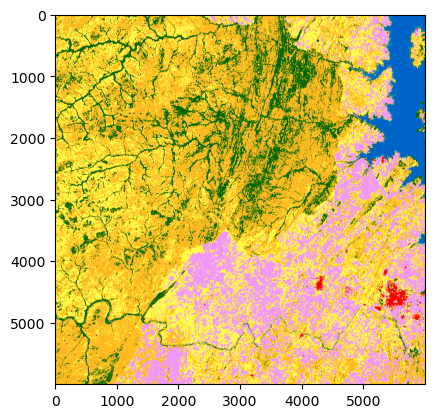

In [9]:
import matplotlib.pyplot as plt

rgb_data = label_to_rgb(img.data[0])
fig, ax = plt.subplots()
ax.imshow(rgb_data)

/var/folders/3p/7044wnn96f970j23ks8v97240000gn/T/ipykernel_30266/3092487147.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


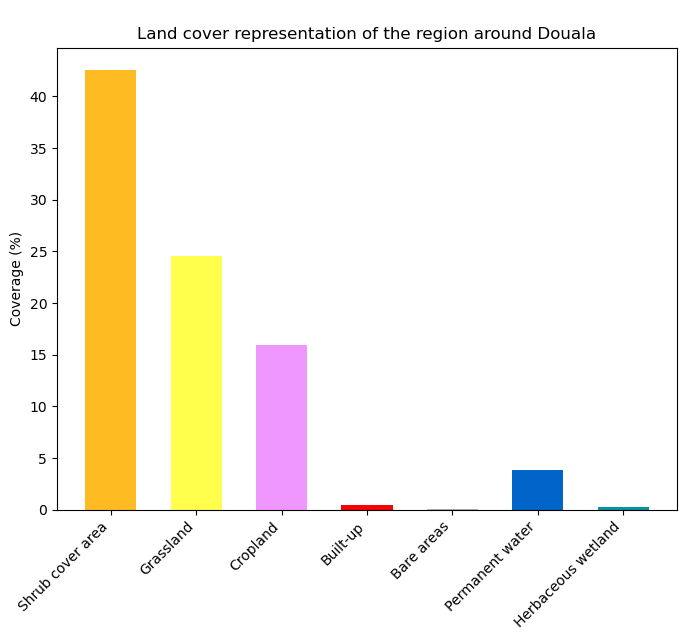

In [10]:
values, occurences = np.unique(img.data[0], return_counts=True)


occurences = occurences / occurences.sum() * 100
label_names = [legend_dict[val] for val in values]
values_colors = label_to_rgb(values.reshape(-1, 1)).squeeze()


fix, ax = plt.subplots(figsize=(8, 6))
ax.bar(x=label_names[1:], height=occurences[1:], color=values_colors[1:], width=0.6)
ax.set_title('\nLand cover representation of the region around Douala')
ax.set
ax.set_ylabel('Coverage (%)')
plt.xticks(rotation=45, ha='right')
fig.show()